# Explore Microbe Community
> Gati Aher, SUM2021

Process Data
* import data from csv
* clean data by removing negligible / bad OTUs
* standardize data to relative abundances
* save data

Explore Data
* visualize the OTUs abundances in the original community
* perform alpha diversity analysis on the original community
    * analyze variety of OTUs
* perform beta diversity analysis to compare the effects of perturbations
    * analyze compositional shift of OTUs with PCoA on Bray-Curtis dissimlarity matrix

To download notebook as pdf, follow: https://towardsdatascience.com/jupyter-notebook-to-pdf-in-a-few-lines-3c48d68a7a63

## TODO
* TODO: taxonomy
    * get taxonomy file and do analysis at multiple levels
    * figure out what OTUs to condense (based on phylogenetic / dendogram analysis)
* TODO: alpha and beta diversity real statistical analysis
    * figure out how to do multiple corrections for factors?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

## Set Up Consistent Styling

*Key:*
- Shape indicates current carbon source
- Color indicates carbon series
- Marker Edge Width indicates day
- Marker Color indicates transfer series

In [2]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [3]:
map_carbon_shapes = {
    "C0": "o",
    "C": "o",
    "G": "s",
    "M": "^",
}

def_marker_size = 10

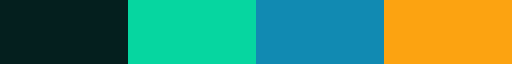

In [4]:
def_color = "#041F1E"
def_line_color = "#707070"

colors = [
    "#041F1E", # original community 
    "#06D6A0", # cellulose
    "#118AB2", # glucose
    "#FCA311", # malate
]
map_carbon_colors = {
    "C0": colors[0],
    "C": colors[1],
    "G": colors[2],
    "M": colors[3],
}
cmap = ListedColormap(colors, name="carbon")
cmap

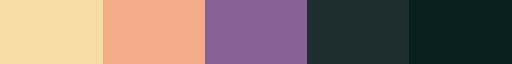

In [5]:
map_days_widths = {
    "C0": 0,
    "3": 1,
    "5": 2,
    "7": 3,
    "10": 4,
    "20": 5,
}

colors_days = [
    "#F7DBA7", # 3
    "#F1AB86", # 5
    "#876194", # 7
    "#1E2D2F", # 10
    "#041F1E", # 20
]

map_days_colors = {
    "3": colors_days[0],
    "5": colors_days[1],
    "7": colors_days[2],
    "10": colors_days[3],
    "20": colors_days[4],
}

cmap_days = ListedColormap(colors_days, name="days")
cmap_days

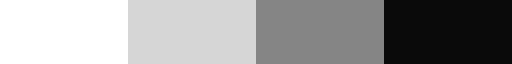

In [6]:
colors_transfers = [
    "#FFFFFF", # C0
    "#D6D6D6", # 1
    "#858585", # 2
    "#0A0A0A", # 3
]

map_transfers_colors = {
    "C0": colors_transfers[0],
    "1": colors_transfers[1],
    "2": colors_transfers[2],
    "3": colors_transfers[3],
}

cmap_transfers = ListedColormap(colors_transfers, name="transfers")
cmap_transfers

## Process Data

### Import Data

We are working with three files:
* `<counts>.csv`: OTUs x sample
* `<annotations>.csv`: sample x variables
* `<taxonomy>.csv`: OTUs x taxonomy (TODO: don't have this)

OTUs and samples must be in the same order for all files

In [7]:
df_counts = pd.read_csv("data/FCF_master.csv", index_col=0).T
df_annotations_from_file = pd.read_csv("data/FCF_annotations.csv", index_col=0) # these aren't in the right order

In [8]:
print("df_counts.shape", df_counts.shape)
df_counts.head()

df_counts.shape (87, 153)


,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,bosea spp.,corynebacterium durum,rubrivivax gelatinosus,anaerococcus hydrogenalis,globicatella spp.,finegoldia magna,dietzia spp.,granulicatella elegans,actinomyces marimammalium,veillonella dispar
C0C,18304,16452,9817,9279,6578,6400,5409,4521,3913,1958,...,0,0,0,0,0,0,0,0,0,0
1C3A,19239,4060,13664,9191,902,1891,3647,2798,1163,257,...,0,0,0,0,0,0,0,0,0,0
1C3B,34155,6121,19194,13838,1395,3117,4828,3858,1357,221,...,0,0,1,0,0,0,0,0,0,0
1C5A,16237,1967,24640,8188,720,1520,2641,2308,2046,265,...,0,0,1,0,0,0,0,0,0,0
1C5B,23247,6002,16356,16142,1381,4462,6110,4695,3101,605,...,0,1,0,0,0,0,0,0,0,0


In [9]:
print("df_annotations_from_file.shape", df_annotations_from_file.shape)
df_annotations_from_file.head()

df_annotations_from_file.shape (87, 3)


,series,food,day
C0C,C0,cellulose,10
1C3A,1C,cellulose,3
1C3B,1C,cellulose,3
1C5A,1C,cellulose,5
1C5B,1C,cellulose,5


In [10]:
df_annotations_from_file.index == df_counts.index # these aren't in the right order

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [11]:
# Build Correct Annotations File
# columns: index series carbon transfer day
df_annotations = pd.DataFrame(index=df_counts.index)
ann_series = []
ann_carbon = []
ann_transfer = []
ann_day = list(map(str, df_annotations_from_file["day"].values))

for i in df_counts.index:
    # series
    if i == "C0C":
        ann_series.append("C0")
    else:
        ann_series.append(i[1])
    # carbon
    if i == "C0C":
        ann_carbon.append("C0")
    elif df_annotations_from_file.loc[i, "food"] == "cellulose":
        ann_carbon.append("C")
    elif df_annotations_from_file.loc[i, "food"] == "glucose":
        ann_carbon.append("G")
    elif df_annotations_from_file.loc[i, "food"] == "malate":
        ann_carbon.append("M")
    else:
        ann_carbon.append("X")
    # transfer
    if i == "C0C":
        ann_transfer.append("C0")
    else:
        ann_transfer.append(i[0])

df_annotations["series"] = ann_series
df_annotations["carbon"] = ann_carbon
df_annotations["transfer"] = ann_transfer
df_annotations["day"] = ann_day

df_annotations

,series,carbon,transfer,day
C0C,C0,C0,C0,10
1C3A,C,C,1,3
1C3B,C,C,1,3
1C5A,C,C,1,5
1C5B,C,C,1,5
...,...,...,...,...
3G7A,G,C,3,7
3G7B,G,C,3,7
3G7C,G,C,3,7
3G10A,G,C,3,10


### Remove noisy data (OTUs that do not appear consistently)

* NOTE: 3G10C was removed because it might be a wrongly labeled result
* remove OTUs not in original sample (TODO: ask Jean if this is valid)
* remove OTUs with less than total threshold read counts across all samples
* TODO: remove OTUs that don't occur in enough samples

In [12]:
# remove OTUs not in original sample
threshold = 1
not_in_original = df_counts.columns[df_counts.loc['C0C'] < threshold]
# --- what OTUs are not in original sample?
print("Throw out OTUs that were not in origianl C0C community:", not_in_original, "length:", len(not_in_original))
df_not_in_original = df_counts[not_in_original]
df_not_in_original.sum(axis=0)

Throw out OTUs that were not in origianl C0C community: Index(['pseudomonas veronii', 'streptococcus salivarius',
       'stenotrophomonas spp.', 'zoogloea sp.', 'bordetella hinzii',
       'cytophaga spp.', 'rhizobium straminoryzae', 'methanosaeta sp.',
       'pontibacter korlensis', 'bacteroides fragilis',
       'sphingobium yanoikuyae', 'rhodothermus spp.', 'rhodovibrio sodomensis',
       'rhizobium sp.', 'enterobacter sp.', 'gemmatimonas spp.',
       'bacteroides caccae', 'eubacterium rectale', 'citrobacter sp.',
       'pseudomonas spp.', 'hydrogenophaga spp.', 'atopostipes sp.',
       'rhodovibrio spp.', 'ochrobactrum intermedium',
       'pseudochrobactrum kiredjianiae', 'steroidobacter spp.',
       'oligotropha carboxidovorans', 'salinibacter spp.',
       'pantoea agglomerans', 'chelatococcus spp.', 'streptococcus sanguinis',
       'afipia broomeae', 'prevotella sp.', 'thioalkalivibrio spp.',
       'methyloligella halotolerans', 'rhodopseudomonas oryzae',
       'porph

pseudomonas veronii          4119
streptococcus salivarius     2503
stenotrophomonas spp.         114
zoogloea sp.                   62
bordetella hinzii              29
                             ... 
finegoldia magna                4
dietzia spp.                    4
granulicatella elegans          4
actinomyces marimammalium       3
veillonella dispar              3
Length: 84, dtype: int64

In [13]:
df_counts = df_counts.drop(not_in_original, axis=1)
df_counts

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,escherichia vulneris,brevundimonas spp.,parabacteroides distasonis,nitrobacter hamburgensis,vitis vinifera,methylocystis heyerii,micrococcus luteus,delftia sp.,methylobacillus sp.,rhodobacter capsulatus
C0C,18304,16452,9817,9279,6578,6400,5409,4521,3913,1958,...,1,1,1,1,1,1,1,1,1,1
1C3A,19239,4060,13664,9191,902,1891,3647,2798,1163,257,...,0,0,0,0,0,0,0,0,0,0
1C3B,34155,6121,19194,13838,1395,3117,4828,3858,1357,221,...,2,0,0,0,1,0,0,0,0,0
1C5A,16237,1967,24640,8188,720,1520,2641,2308,2046,265,...,5,8,0,2,0,0,0,0,0,0
1C5B,23247,6002,16356,16142,1381,4462,6110,4695,3101,605,...,10,2,1,4,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3G7A,25593,319,3256,11598,10247,69747,28315,891,7625,15,...,5,0,3,0,0,1,0,0,0,0
3G7B,36316,109,3496,7593,9236,40432,30320,703,3922,15,...,7,0,0,0,0,0,0,0,0,0
3G7C,34948,136,4123,9157,12384,40225,28382,721,4594,16,...,2,5,1,0,0,2,0,0,0,0
3G10A,17610,250,18156,16920,8832,72267,27647,1603,9659,1,...,0,0,5,0,0,1,0,0,0,0


In [14]:
# remove OTUs with less than threshold read counts
threshold = 20
too_low_read_counts = df_counts.columns[df_counts.sum(axis=0) < threshold]
# --- what OTUs have too low read counts?
print("Throw out OTUs with low read counts:", too_low_read_counts, "length:", len(too_low_read_counts))
df_too_low_read_counts = df_counts[too_low_read_counts]
df_too_low_read_counts.sum(axis=0)

Throw out OTUs with low read counts: Index(['desulfovibrio desulfuricans', 'bradyrhizobium elkanii',
       'clostridium spp.', 'vitis vinifera', 'methylocystis heyerii',
       'micrococcus luteus', 'delftia sp.', 'methylobacillus sp.',
       'rhodobacter capsulatus'],
      dtype='object') length: 9


desulfovibrio desulfuricans     5
bradyrhizobium elkanii          7
clostridium spp.                6
vitis vinifera                 19
methylocystis heyerii          14
micrococcus luteus              5
delftia sp.                     4
methylobacillus sp.             3
rhodobacter capsulatus          3
dtype: int64

In [15]:
df_counts = df_counts.drop(too_low_read_counts, axis=1)
df_counts

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,ochrobactrum anthropi,nitrospirillum azospirillum amazonense,acinetobacter junii,propionibacterium acnes,brevundimonas sp.,rhizobium petrolearium,escherichia vulneris,brevundimonas spp.,parabacteroides distasonis,nitrobacter hamburgensis
C0C,18304,16452,9817,9279,6578,6400,5409,4521,3913,1958,...,1,1,1,1,1,1,1,1,1,1
1C3A,19239,4060,13664,9191,902,1891,3647,2798,1163,257,...,4,0,0,3,1,0,0,0,0,0
1C3B,34155,6121,19194,13838,1395,3117,4828,3858,1357,221,...,5,2,4,1,0,1,2,0,0,0
1C5A,16237,1967,24640,8188,720,1520,2641,2308,2046,265,...,24,70,0,1,24,0,5,8,0,2
1C5B,23247,6002,16356,16142,1381,4462,6110,4695,3101,605,...,20,53,1,1,16,1,10,2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3G7A,25593,319,3256,11598,10247,69747,28315,891,7625,15,...,22,7,0,2,5,8,5,0,3,0
3G7B,36316,109,3496,7593,9236,40432,30320,703,3922,15,...,15,4,0,0,0,11,7,0,0,0
3G7C,34948,136,4123,9157,12384,40225,28382,721,4594,16,...,28,12,0,1,4,4,2,5,1,0
3G10A,17610,250,18156,16920,8832,72267,27647,1603,9659,1,...,4,1,16,0,0,1,0,0,5,0


### Standardize Data

Transform absolute counts to relative abundances.
Relative counts for a sample should add up to 1. Do this by dividing counts in each sample by total counts in sample.

In [16]:
df_counts_rel = df_counts.div(df_counts.sum(axis=1), axis=0)
df_counts_rel.head()

,opitutus spp.,paludibacter propionicigenes,magnetospirillum sp.,rhodopseudomonas palustris,acetobacter spp.,bacteroides spp.,pleomorphomonas oryzae,afipia sp.,rhodoblastus acidophilus,spirochaeta spp.,...,ochrobactrum anthropi,nitrospirillum azospirillum amazonense,acinetobacter junii,propionibacterium acnes,brevundimonas sp.,rhizobium petrolearium,escherichia vulneris,brevundimonas spp.,parabacteroides distasonis,nitrobacter hamburgensis
C0C,0.207712,0.186696,0.111402,0.105297,0.074647,0.072627,0.061381,0.051304,0.044404,0.022219,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
1C3A,0.267023,0.056350,0.189646,0.127564,0.012519,0.026246,0.050618,0.038834,0.016142,0.003567,...,0.000056,0.000000,0.000000,0.000042,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000
1C3B,0.290520,0.052065,0.163263,0.117705,0.011866,0.026513,0.041067,0.032816,0.011543,0.001880,...,0.000043,0.000017,0.000034,0.000009,0.000000,0.000009,0.000017,0.000000,0.000000,0.000000
1C5A,0.194220,0.023528,0.294733,0.097941,0.008612,0.018182,0.031591,0.027607,0.024473,0.003170,...,0.000287,0.000837,0.000000,0.000012,0.000287,0.000000,0.000060,0.000096,0.000000,0.000024
1C5B,0.187924,0.048519,0.132219,0.130489,0.011164,0.036070,0.049392,0.037954,0.025068,0.004891,...,0.000162,0.000428,0.000008,0.000008,0.000129,0.000008,0.000081,0.000016,0.000008,0.000032


In [17]:
# check that samples sum to 1
df_counts_rel.sum(axis=1)

C0C      1.0
1C3A     1.0
1C3B     1.0
1C5A     1.0
1C5B     1.0
        ... 
3G7A     1.0
3G7B     1.0
3G7C     1.0
3G10A    1.0
3G10B    1.0
Length: 87, dtype: float64

### Save Data
Uncomment to save cleaned relative counts

In [18]:
# df_counts_rel.to_csv("data/FCF_relative_counts.csv")
# df_annotations.to_csv("data/FCF_annotations_corrected.csv")
print("df_counts_rel.values.shape", df_counts_rel.values.shape)
print("df_annotations.values.shape", df_annotations.values.shape)

df_counts_rel.values.shape (87, 60)
df_annotations.values.shape (87, 4)


## Explore Data

* TODO: actual statistical metrics and analysis of alpha and beta diversity
* TODO: delineate best groupings to analyze

### Alpha Diversity Analysis

Measures who is there  
1.) richness of species distribution  
2.) eveness of species distribution  

Alpha analysis figures out how many OTUs exist, figure out how many taxa there are

In [19]:
from collections import Counter

In [20]:
original = df_counts_rel.loc['C0C']
labels = original.index
family_labels = [i.split()[0] for i in labels]
family_count = Counter(family_labels)

Text(0.5, 0, 'OTUs')

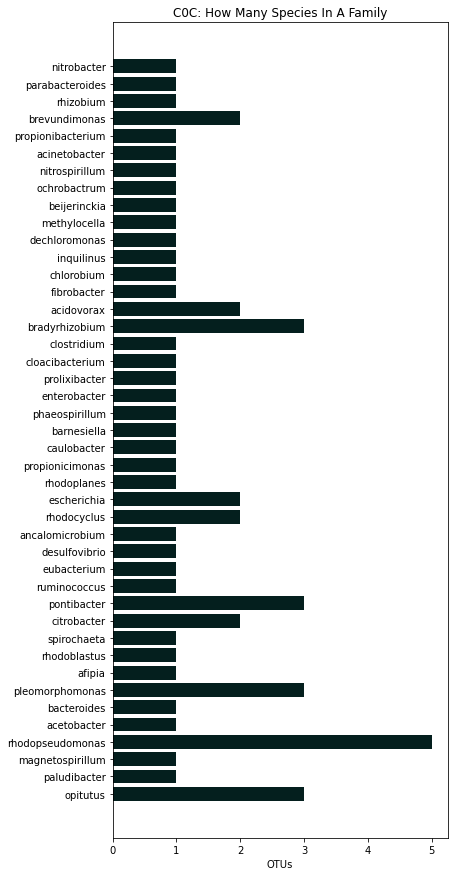

In [48]:
# just get a sense of how many species are in a family
f, ax = plt.subplots(figsize=(6, 15))
ax.barh(list(family_count.keys()), list(family_count.values()), color=def_color)
ax.set_title("C0C: How Many Species In A Family")
ax.set_xlabel("OTUs")

Text(0.5, 0, 'Summed Absolute OTU Read Counts')

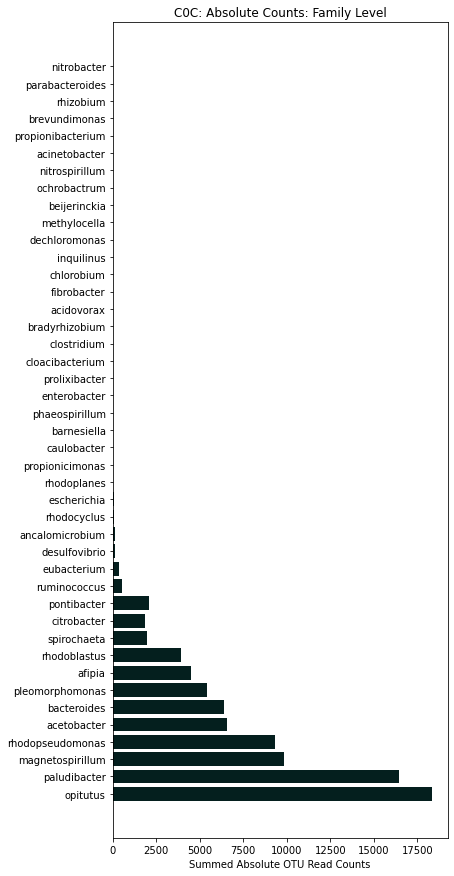

In [22]:
original = df_counts.loc['C0C']
col_mapper = {i: i.split()[0] for i in original.index}
original_by_family = original.rename(col_mapper)
original_by_family = original_by_family.groupby(level=0, sort=False).sum()

searchstring = "C0C"
f, ax = plt.subplots(figsize=(6, 15))
for sample_label in df_counts_rel.index:
    if sample_label.startswith(searchstring):
        data = original_by_family
        # set plot variables
        carbon_style = map_carbon_colors["C0"]
        series_style = map_carbon_shapes["C0"]
        day_style = 0
        transfer_style = None      
        ax.barh(data.index, data.values, color=def_color)
ax.set_title("{}: Absolute Counts: Family Level".format(searchstring))
ax.set_xlabel("Summed Absolute OTU Read Counts")

Text(0.5, 0, 'Summed Relative OTU Read Counts')

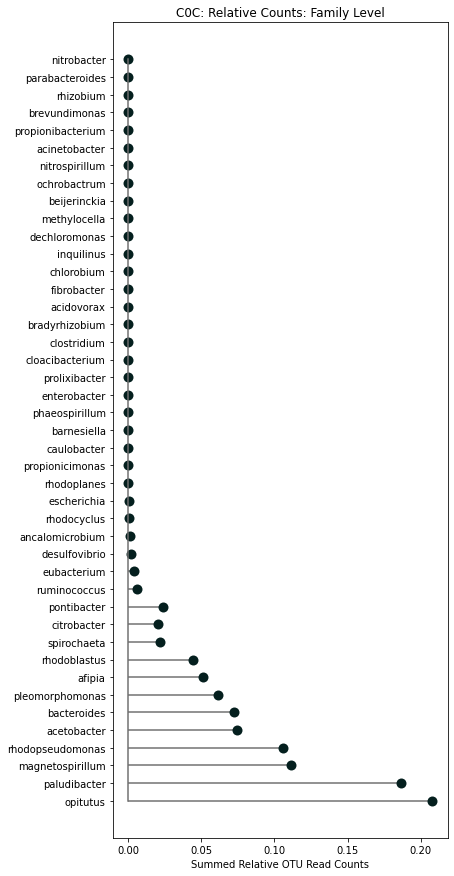

In [23]:
original = df_counts_rel.loc['C0C']
col_mapper = {i: i.split()[0] for i in original.index}
original_by_family = original.rename(col_mapper)
original_by_family = original_by_family.groupby(level=0, sort=False).sum()

searchstring = "C0C"
f, ax = plt.subplots(figsize=(6, 15))
for sample_label in df_counts_rel.index:
    if sample_label.startswith(searchstring):
        data = original_by_family
        # set plot variables
        series_style = map_carbon_colors["C0"]
        carbon_style = map_carbon_shapes["C0"]
        day_style = map_days_widths['C0']
        transfer_style = map_transfers_colors['C0']        
        # set plot styling
        (markerline, stemlines, baseline) = ax.stem(data.index, data.values, orientation="horizontal")
        plt.setp(markerline, markersize=def_marker_size, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
        plt.setp(stemlines, "color", def_line_color)
        plt.setp(baseline, "color", def_line_color)
#         ax.barh(data.index, data.values, color=def_color)
ax.set_title("{}: Relative Counts: Family Level".format(searchstring))
ax.set_xlabel("Summed Relative OTU Read Counts")

### Beta Analysis

Make bar charts to:
* Observe original community
* Observe composition shift as effect of carbon perturbation
* Make sure no samples look weird

Log Scale is favorable because small fluctuations in large numbers do not matter as much

### Original Community

Text(0.5, 0, 'Absolute Counts')

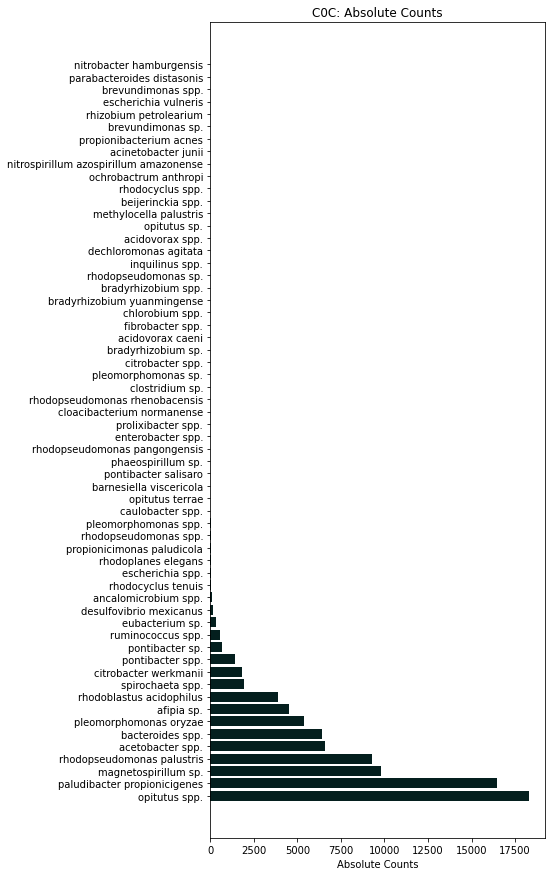

In [24]:
data = df_counts.loc['C0C']
f, ax = plt.subplots(figsize=(6, 15))
ax.barh(data.index, data.values, color=def_color)
ax.set_title("C0C: Absolute Counts")
ax.set_xlabel("Absolute Counts")

Text(0.5, 0, 'Log Absolute Counts')

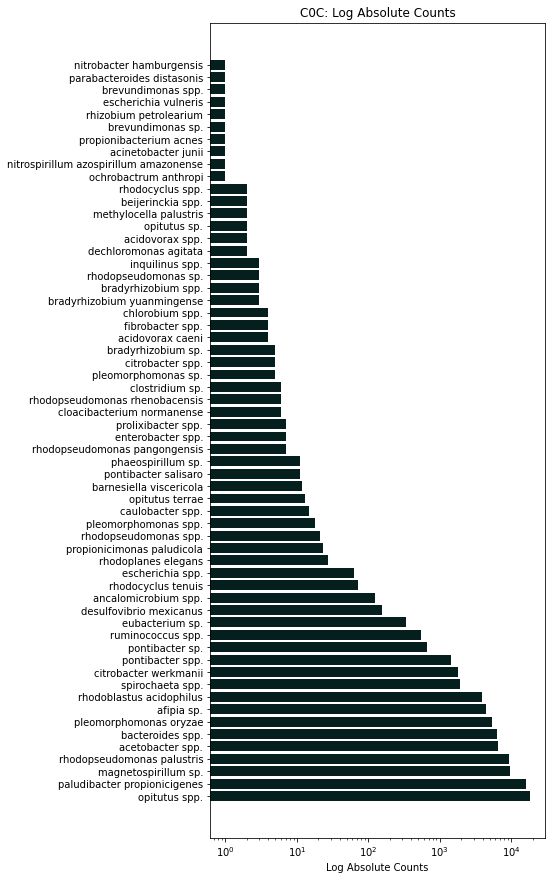

In [25]:
data = df_counts.loc['C0C']
f, ax = plt.subplots(figsize=(6, 15))
ax.barh(data.index, data.values, log=True, color=def_color)
ax.set_title("C0C: Log Absolute Counts")
ax.set_xlabel("Log Absolute Counts")

### Composition Shift

In [26]:
def rel_count_stem(df_counts_rel, df_annotations, searchstring):
    f, ax = plt.subplots(figsize=(6, 15))
    for sample_label in df_counts_rel.index:
        if sample_label.startswith(searchstring):
            data = df_counts_rel.loc[sample_label]
            # set plot variables
            series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
            carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
            day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
            transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
            # set plot styling
            (markerline, stemlines, baseline) = ax.stem(data.index, data.values, orientation="horizontal")
            plt.setp(markerline, markersize=def_marker_size, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
            plt.setp(stemlines, "color", def_line_color)
            plt.setp(baseline, "color", def_line_color)
            plt.xlim([0, 1])
    ax.set_title("{}: Relative Counts".format(searchstring))
    ax.set_xlabel("Relative Counts")

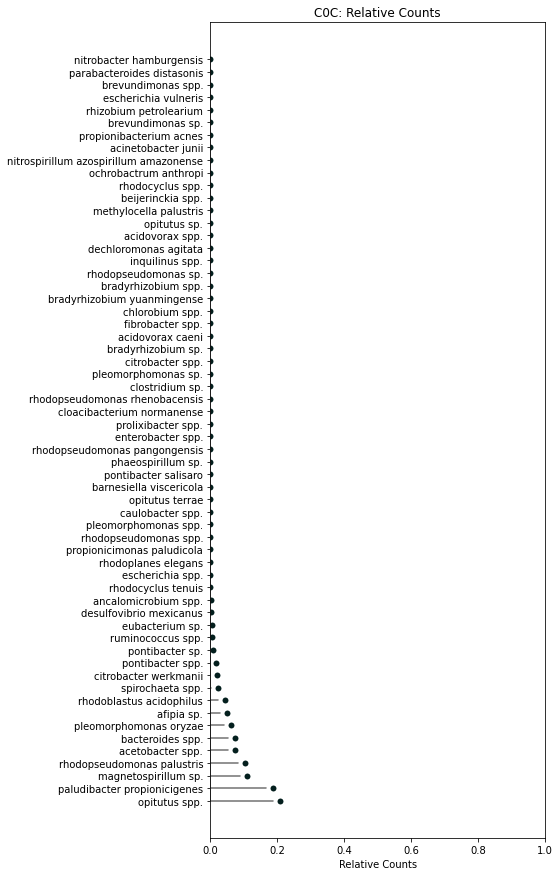

In [27]:
rel_count_stem(df_counts_rel, df_annotations, "C0C")

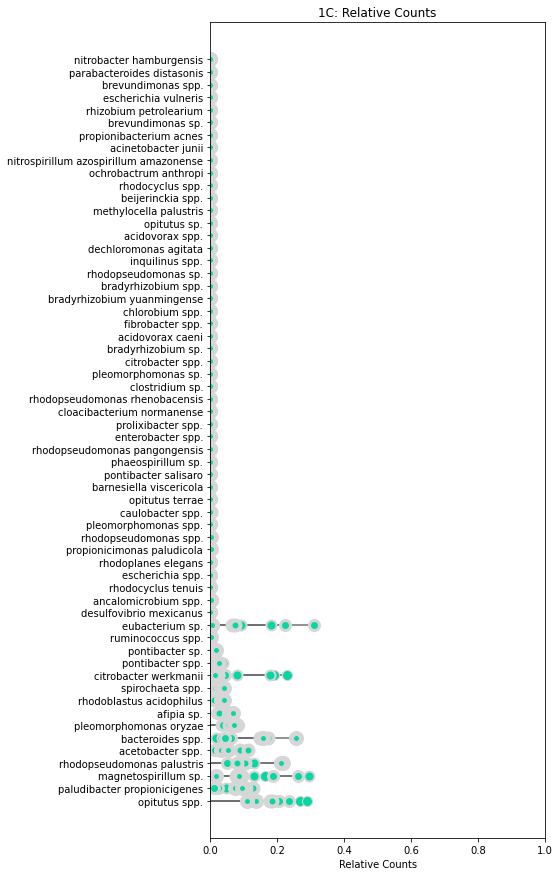

In [28]:
rel_count_stem(df_counts_rel, df_annotations, "1C")

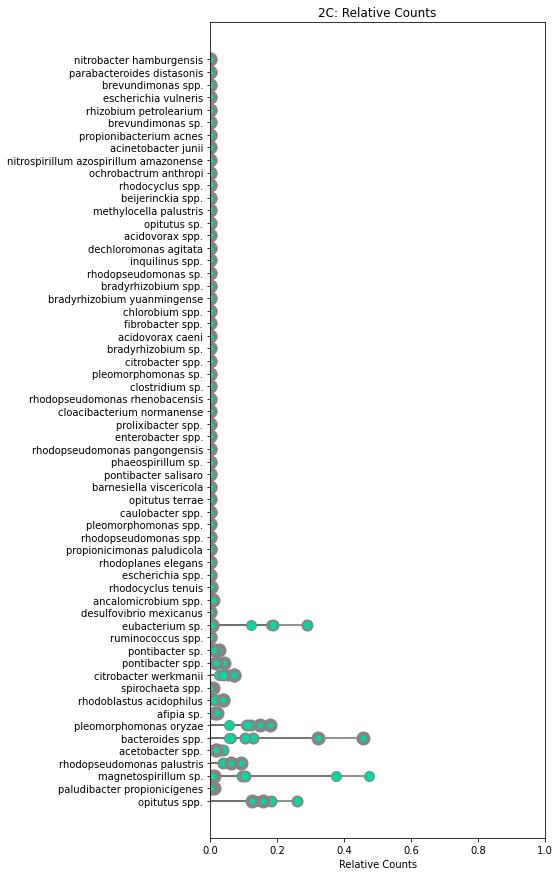

In [29]:
rel_count_stem(df_counts_rel, df_annotations, "2C")

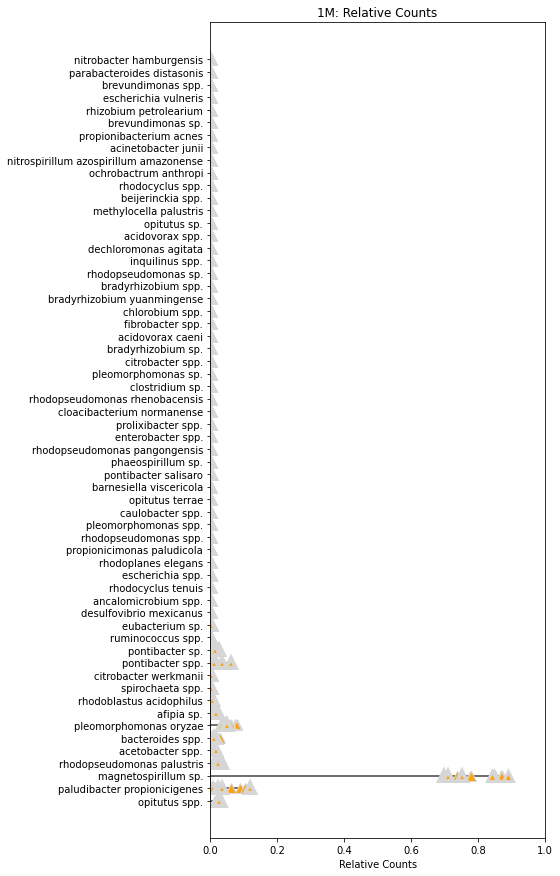

In [30]:
rel_count_stem(df_counts_rel, df_annotations, "1M")

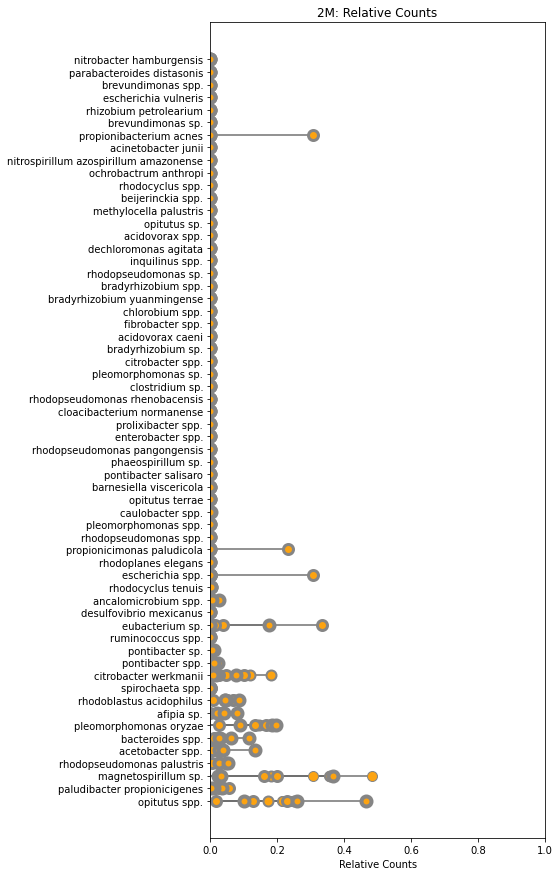

In [31]:
rel_count_stem(df_counts_rel, df_annotations, "2M")

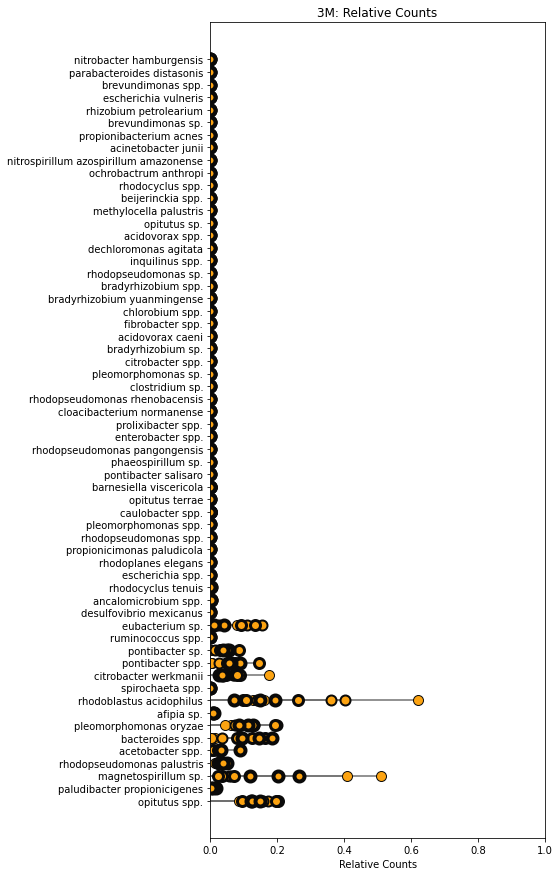

In [32]:
rel_count_stem(df_counts_rel, df_annotations, "3M")

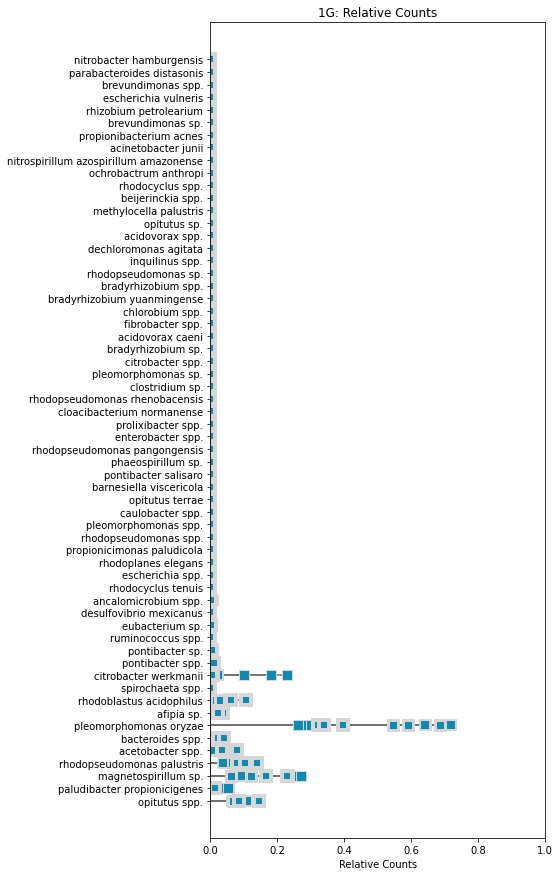

In [33]:
rel_count_stem(df_counts_rel, df_annotations, "1G")

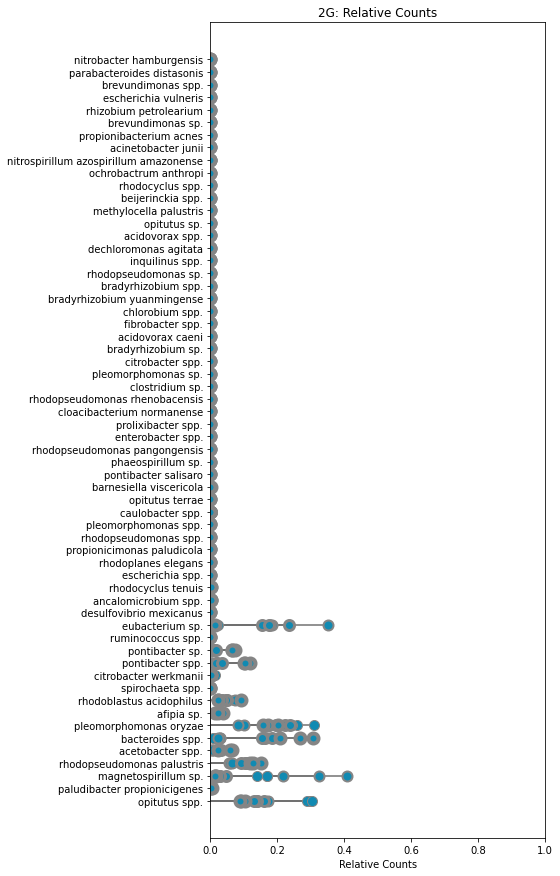

In [34]:
rel_count_stem(df_counts_rel, df_annotations, "2G")

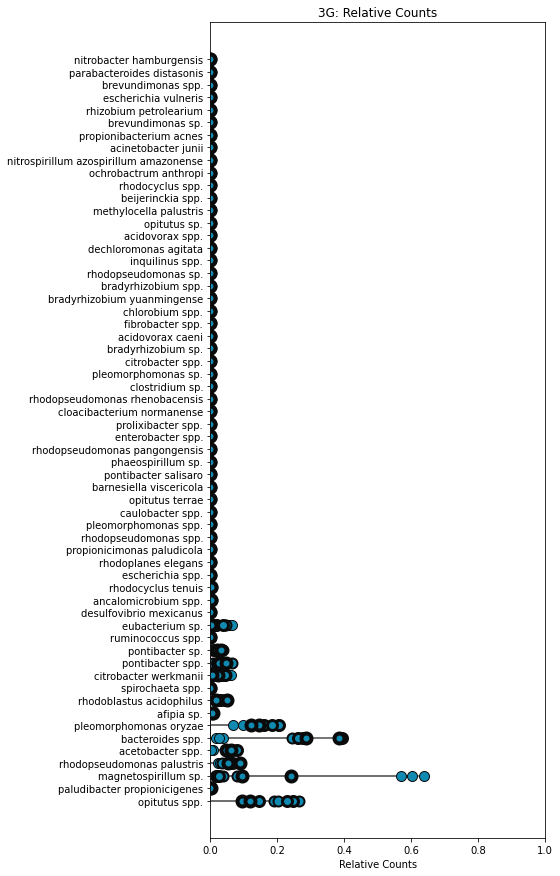

In [35]:
rel_count_stem(df_counts_rel, df_annotations, "3G")

### Beta-Diversity: PCoA with Bray-Curtis Distance
Mesaure differences between samples  
* compute Bray-Curtis distances, a beta diversity distance metric, between all pairs of samples
* perform principal coordinates analysis (PCoA) on the distance matrix
* see how the groups fall (color by factor)

Use Bray-Curtis dissimilarity because it is a better measure of the distance between populations. It is calculated by dividing shared abundance by total abundance. For ANOSIM statistical analysis, a positive value of r statistic indicates clustering, and the p-value is significant at an alpha of 0.1.

Ordination techniques, such as PCoA, are useful for exploratory analysis. The next step is to quantify the strength of the grouping/clustering that we see in ordination plots. There are many statistical methods available to accomplish this; many operate on distance matrices. Let’s use ANOSIM to quantify the strength of the clustering we see in the ordination plots above, using the Bray-Curtis distance matrix and sample metadata.

From the PCoA plots, we can see the clustering of carbon source glucose and carbon source malate. There is also an interesting trend where the left side of the cellulose cluster is from smaller days, and the right side of the cellulose cluster is from larger days, maybe indicating the presence of a transition state? Maybe some bacteria do not transfer well and need a few days to recover?

TODO: make an actual scree plot to show percentage variance explained by 2 or 3 eigenvalues?

*Sources:*  
scikit-bio tutorial

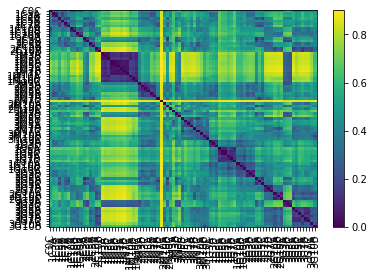

In [36]:
from skbio.diversity import beta_diversity
bc_dm = beta_diversity("braycurtis", df_counts_rel.values, df_counts_rel.index)
bc_dm

In [37]:
from skbio.stats.ordination import pcoa
bc_pc = pcoa(bc_dm)
bc_pc_cum_sum = bc_pc.eigvals / bc_pc.eigvals.sum()


num_comp = 2
print(num_comp, "Components Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))

num_comp = 3
print(num_comp, "Components Explained Variance:", sum(bc_pc_cum_sum[0:num_comp]))

2 Components Explained Variance: 0.5272892910459005
3 Components Explained Variance: 0.6273218155542463


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.17415831440648843 and the largest is 5.697363488611947.
  warn(


In [38]:
bc_pc.samples

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87
C0C,-0.118473,-0.040791,0.003594,-0.236450,0.096253,0.094486,0.122100,-0.123835,-0.010679,0.066831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C3A,0.007194,0.028954,0.169968,-0.244901,0.193910,0.015144,0.013872,0.055638,-0.006167,-0.037025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C3B,-0.012851,0.036431,0.182384,-0.251197,0.209163,0.033677,-0.002301,0.058480,-0.020875,-0.027864,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C5A,0.085622,-0.090356,0.214688,-0.136277,-0.078916,0.032647,-0.025952,0.064119,0.017580,-0.064788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1C5B,-0.076006,-0.067289,0.151378,-0.173959,0.071287,0.067691,0.082688,0.132588,-0.060803,-0.037799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3G7A,-0.303995,-0.090484,-0.195934,0.035112,0.004603,-0.048990,-0.075445,-0.013802,-0.035015,-0.048020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G7B,-0.311526,-0.033321,-0.104755,-0.018598,0.055582,-0.047740,-0.138101,-0.093139,-0.009655,0.005729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G7C,-0.304203,-0.070833,-0.073814,-0.021135,0.032581,-0.040066,-0.128781,-0.077110,-0.033523,-0.001611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3G10A,-0.220463,-0.021441,-0.224749,-0.008318,-0.011835,-0.046924,-0.010949,0.013990,-0.036596,-0.047148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
from skbio.stats.distance import anosim

In [40]:
results = anosim(bc_dm, df_annotations, column='carbon', permutations=999)
print("carbon clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='day', permutations=999)
print("day clustering", results['test statistic'])
print("\t p-value", results['p-value'])

results = anosim(bc_dm, df_annotations, column='transfer', permutations=999)
print("transfer clustering", results['test statistic'])
print("\t p-value", results['p-value'])                                                                                                                                

carbon clustering 0.548044404367239
	 p-value 0.001
day clustering 0.13217302797343009
	 p-value 0.001
transfer clustering 0.1638186772097984
	 p-value 0.001


Text(0, 0.5, 'PC 2')

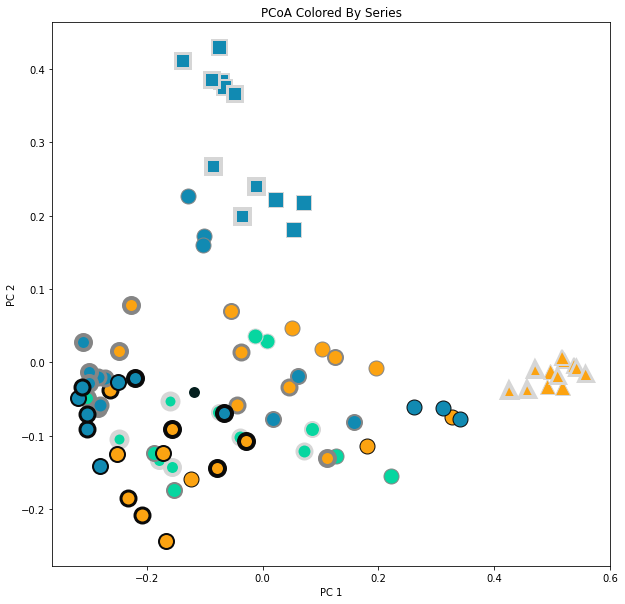

In [41]:
f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA Colored By Series")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

Text(0, 0.5, 'PC 2')

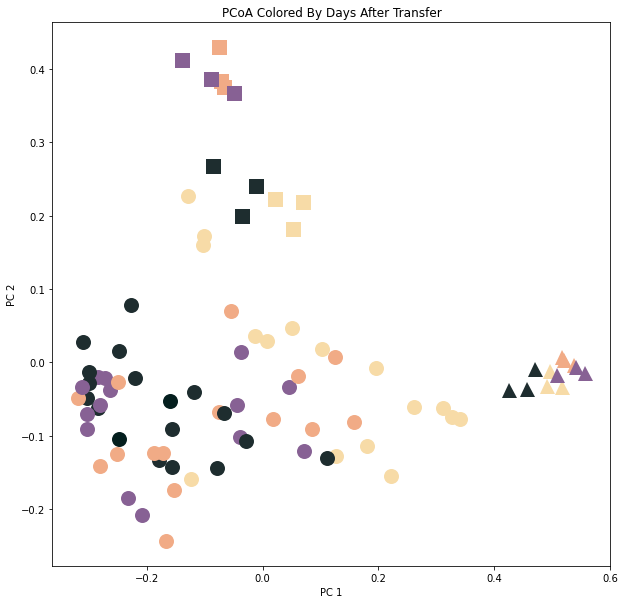

In [42]:
f, ax = plt.subplots(figsize=(10, 10))
for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"])
    plt.setp(plotline, markersize=15, color=day_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=0)
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

Text(0.5, 0, 'PC 3')

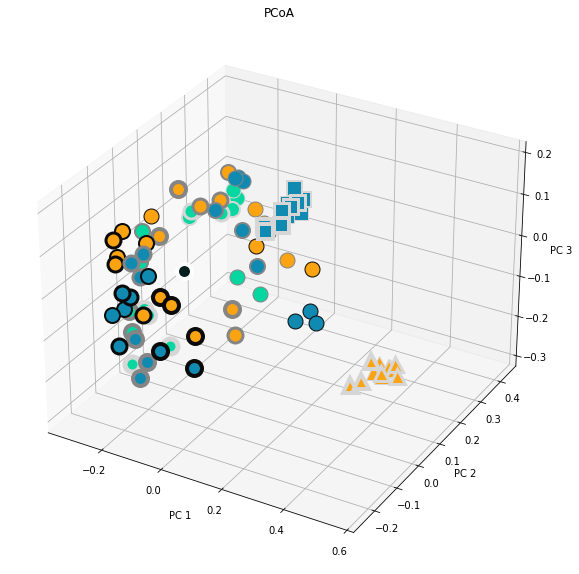

In [43]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_widths[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=transfer_style, markeredgewidth=day_style)
ax.set_title("PCoA")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

Text(0.5, 0, 'PC 3')

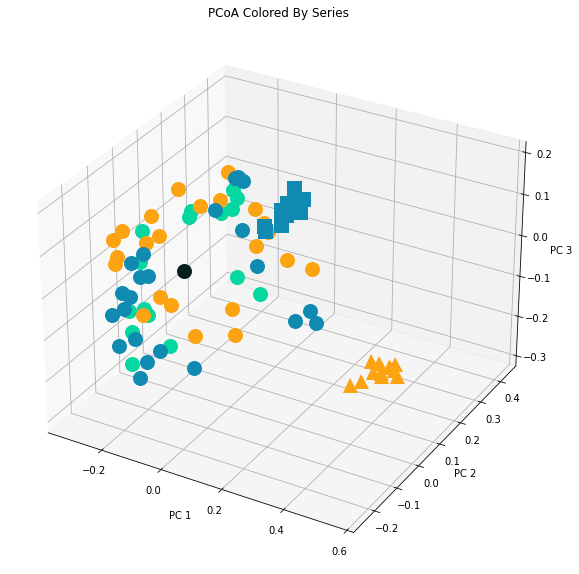

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    series_style = map_carbon_colors[df_annotations.loc[sample_label, "series"]]
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=series_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Series")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

Text(0.5, 0, 'PC 3')

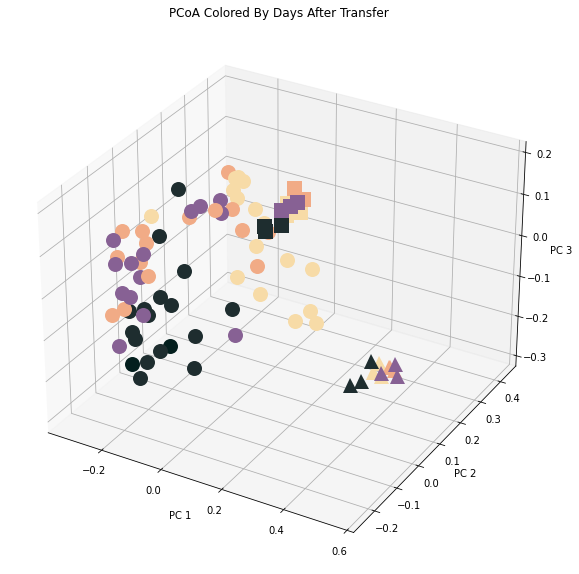

In [45]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=day_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Days After Transfer")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

Text(0.5, 0, 'PC 3')

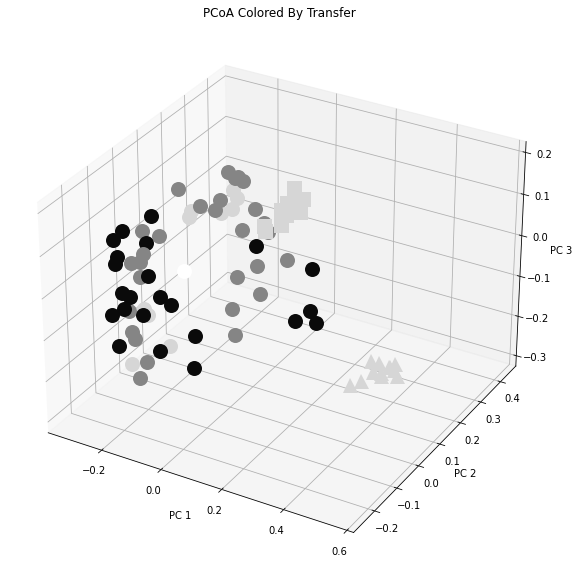

In [46]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

for sample_label in df_counts_rel.index:
    data = bc_pc.samples.loc[sample_label]
    # set plot variables
    carbon_style = map_carbon_shapes[df_annotations.loc[sample_label, "carbon"]]
    day_style = map_days_colors[df_annotations.loc[sample_label, "day"]]
    transfer_style = map_transfers_colors[df_annotations.loc[sample_label, "transfer"]]    
    # set plot styling
    plotline = ax.plot(data["PC1"], data["PC2"], data["PC3"])
    plt.setp(plotline, markersize=15, color=transfer_style, marker=carbon_style, markeredgecolor=None, markeredgewidth=0)
ax.set_title("PCoA Colored By Transfer")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")